# Active Learning

Active learning is a machine learning technique that aims to select the most informative data points for training a model {cite}`settles2009active`. In the context of causal inference, active learning can be particularly useful for efficiently estimating parameters when data collection is limited or expensive. By selectively choosing the most informative samples, we can improve the estimation accuracy of causal effects with fewer data points.

## Active Learning Scenarions
Active learning involves iteratively selecting the most informative data points to be labeled and added to the training set. The main scenarios of active learning include:
1. **Pool-based active learning**: starting with a large pool of unlabeled data, the algorithm selects the most informative samples to label.
2. **Stream-based active learning**: samples arrive in a stream, and the algorithm decides whether to label each incoming sample.
3. **Query synthesis**: the algorithm generates new samples to query an oracle for their labels.


Consider the case where we want to estimate the effect of a variable using a linear model of the kind:

\begin{equation}
    y = X \beta + \epsilon
\end{equation}

where:
- $y$ is the response variable.
- $X$ is the design matrix containing the input variables.
- $\beta$ is the vector of coefficients.
- $\epsilon$ is the error term, assumed to be normally distributed with mean zero and variance $\sigma^2$.

The goal is to estimate the coefficients $\beta$ using the observed data. The variance of the coefficients $\beta$ can be computed as:

\begin{equation}
    \text{Var}(\beta) = \sigma^2 (X^T X)^{-1}
\end{equation}

where $\sigma^2$ is the variance of the residuals, and $(X^T X)^{-1}$ is the inverse of the information matrix.

In the context of linear models, **prediction variance** is a measure of the uncertainty associated with the predictions made by the model.
In active learning, we can use the prediction variance to identify the most informative data points. The idea is to select the points that, when added to the training set, will most reduce the uncertainty in the model's predictions. This is connected with the concept of **D-optimality** discussed in the previous chapter. Indeed, using active learning to select the most informative data points based on prediction variance is analogous to D-optimality. By choosing points that maximize the reduction in prediction variance, we effectively seek to create a design that is close to D-optimal.

Let's create a simple function to compute the prediction variance for a linear model

In [11]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Function to compute variance of coefficients
def compute_variance(X, sigma_squared):
    XTX_inv = np.linalg.inv(X.T @ X)
    return sigma_squared * XTX_inv

Next, we define the function that performs one iteration of active learning. Now, we assume we are in the **pool-based** setting of active learning.

In [12]:
# Function to perform active learning iteration
def active_learning_iteration(X_initial, y_initial, X_pool, y_pool):
    # Train linear regression model
    model = LinearRegression().fit(X_initial, y_initial)
    y_pred_initial = model.predict(X_initial)
    residuals = y_initial - y_pred_initial
    sigma_squared = np.var(residuals)
    variance = compute_variance(X_initial, sigma_squared)
    
    # Select the most informative data points (highest prediction variance)
    prediction_variances = sigma_squared * np.sum((X_pool @ np.linalg.inv(X_initial.T @ X_initial)) * X_pool, axis=1)
    most_informative_idx = np.argmax(prediction_variances)
    X_most_informative = X_pool[most_informative_idx]
    y_most_informative = y_pool[most_informative_idx]

    # Add to the labeled dataset
    X_initial = np.vstack((X_initial, X_most_informative))
    y_initial = np.append(y_initial, y_most_informative)

    # Remove from the pool
    X_pool = np.delete(X_pool, most_informative_idx, axis=0)
    y_pool = np.delete(y_pool, most_informative_idx, axis=0)
    
    return X_initial, y_initial, X_pool, y_pool, np.mean(np.diag(variance))

## Sampling Routine

What do we do, iteratively, in the active learning routine:
- **Training the model**: we fit a linear regression model to the initial labeled dataset.
- **Computing residuals and variance**: the residuals (differences between actual and predicted values) are computed to estimate the variance $\sigma^2$ of the residuals.
- **Selecting the most Informative data point**: the prediction variances are computed for the pool of unlabeled data points. The point with the highest prediction variance is selected as the most informative.
- **Updating the labeled dataset**: the selected data point is added to the labeled dataset, and it is removed from the pool.


For comparison, we also define a random sampling approach, where instead of selecting points with high prediction variance, we just sample data at random from the pool.

In [13]:
# Function to perform random sampling iteration
def random_sampling_iteration(X_initial, y_initial, X_pool, y_pool):
    # Train linear regression model
    model = LinearRegression().fit(X_initial, y_initial)
    y_pred_initial = model.predict(X_initial)
    residuals = y_initial - y_pred_initial
    sigma_squared = np.var(residuals)
    variance = compute_variance(X_initial, sigma_squared)
    
    # Randomly select a data point
    random_idx = np.random.choice(range(X_pool.shape[0]))
    X_random = X_pool[random_idx]
    y_random = y_pool[random_idx]

    # Add to the labeled dataset
    X_initial = np.vstack((X_initial, X_random))
    y_initial = np.append(y_initial, y_random)

    # Remove from the pool
    X_pool = np.delete(X_pool, random_idx, axis=0)
    y_pool = np.delete(y_pool, random_idx, axis=0)
    
    return X_initial, y_initial, X_pool, y_pool, np.mean(np.diag(variance))


Now, we define the function to run the entire active learning simulation, comparing active learning with random sampling over multiple iterations and runs.

In [16]:
# Function to perform the full active learning simulation
def run_active_learning_simulation_with_data_regeneration(n_runs=10, n_iterations=20):
    variances_active_runs = []
    variances_random_runs = []

    for run in range(n_runs):  # Running multiple simulations with different seeds
        # Generate synthetic data
        np.random.seed(run)
        X = np.random.rand(1000, 2)
        true_coefficients = np.array([1.5, -2.0])
        y = X @ true_coefficients + np.random.randn(1000) * 0.5
        
        # Initial small labeled dataset
        initial_indices = np.random.choice(range(1000), size=10, replace=False)
        X_initial, y_initial = X[initial_indices], y[initial_indices]

        # Remaining pool of unlabeled data
        remaining_indices = np.setdiff1d(range(1000), initial_indices)
        X_pool, y_pool = X[remaining_indices], y[remaining_indices]

        # Initialize data for random sampling
        X_initial_random, y_initial_random = X_initial.copy(), y_initial.copy()
        X_pool_random, y_pool_random = X_pool.copy(), y_pool.copy()

        variances_active = []
        variances_random = []

        for iteration in range(n_iterations):
            # Active learning iteration
            X_initial, y_initial, X_pool, y_pool, avg_variance_active = active_learning_iteration(X_initial, y_initial, X_pool, y_pool)
            variances_active.append(avg_variance_active)
    
            # Random sampling iteration
            X_initial_random, y_initial_random, X_pool_random, y_pool_random, avg_variance_random = random_sampling_iteration(X_initial_random, y_initial_random, X_pool_random, y_pool_random)
            variances_random.append(avg_variance_random)

        variances_active_runs.append(variances_active)
        variances_random_runs.append(variances_random)

    return np.array(variances_active_runs), np.array(variances_random_runs)

Finally, we run the simulation and plot the learning curves for active learning and random sampling.

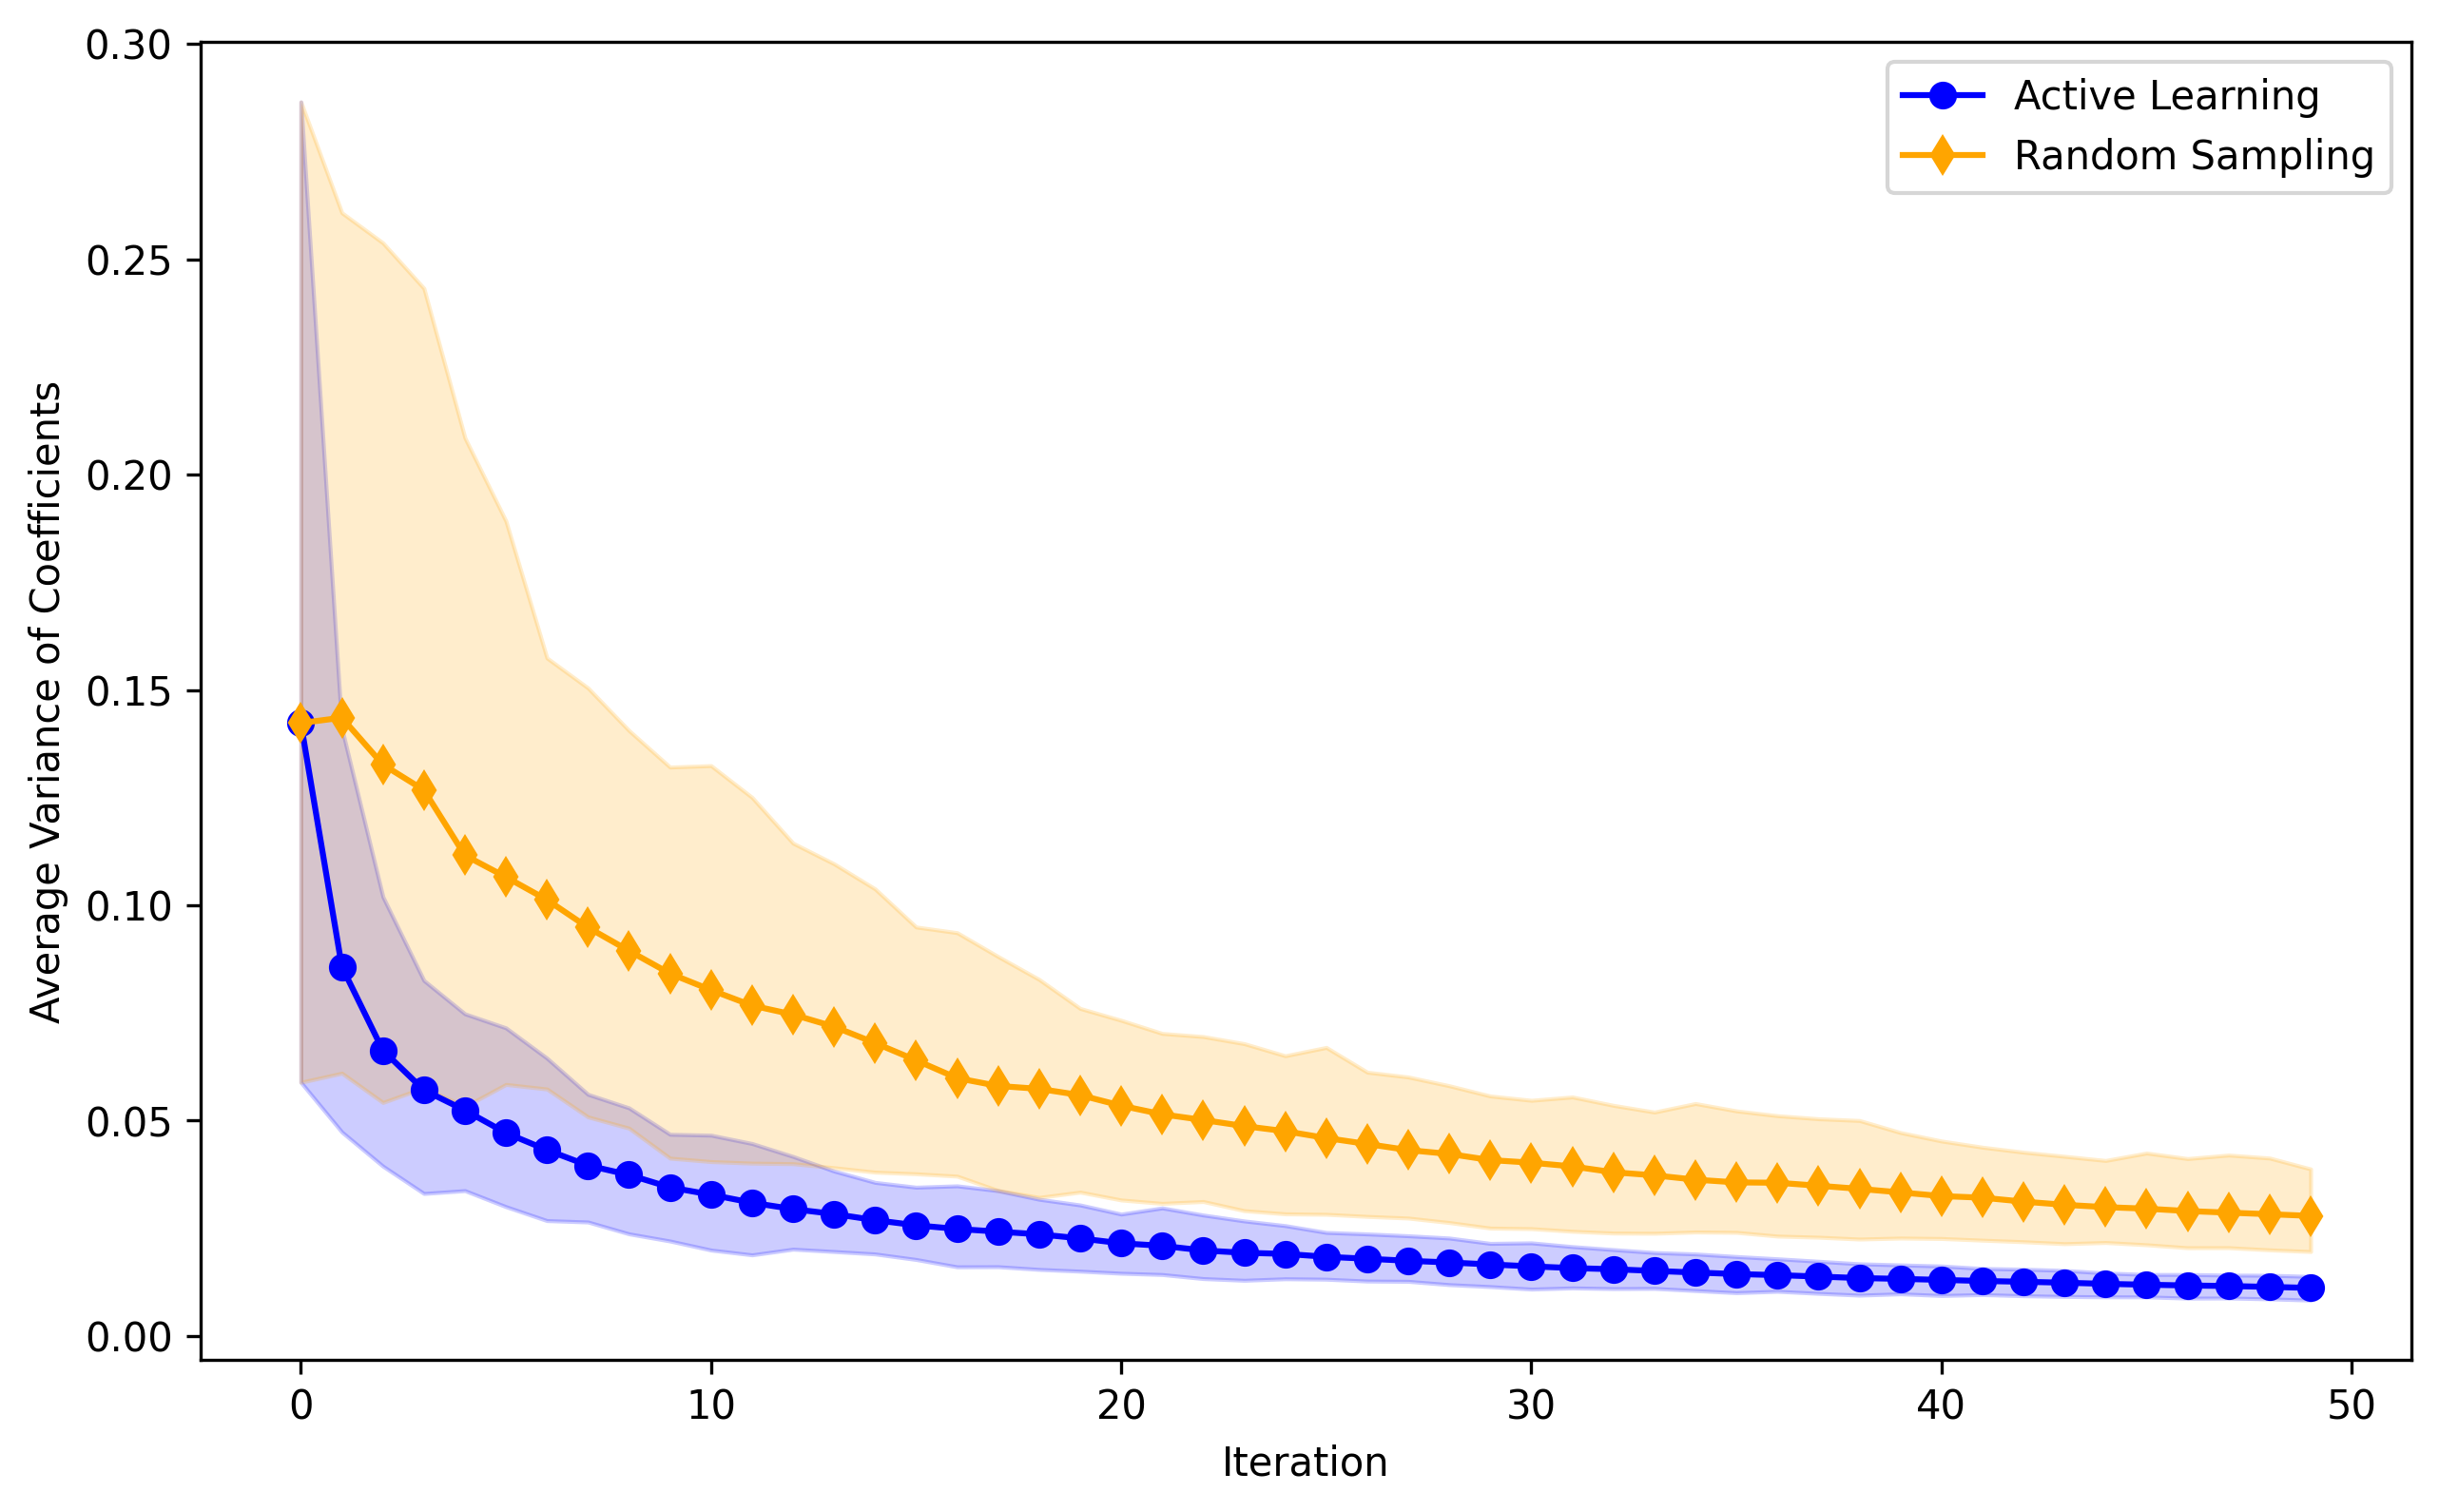

In [18]:
# Run the simulation
variances_active_runs, variances_random_runs = run_active_learning_simulation_with_data_regeneration(n_runs=50, n_iterations=50)

# Compute means and confidence intervals
mean_variances_active = np.mean(variances_active_runs, axis=0)
mean_variances_random = np.mean(variances_random_runs, axis=0)

ci_variances_active_5 = np.percentile(variances_active_runs, 10, axis=0)
ci_variances_active_95 = np.percentile(variances_active_runs, 90, axis=0)
ci_variances_random_5 = np.percentile(variances_random_runs,10, axis=0)
ci_variances_random_95 = np.percentile(variances_random_runs, 90, axis=0)

# Plot the learning curves with shaded regions for confidence intervals
n_iterations = 50
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(mean_variances_active, label='Active Learning', marker='o', color='blue')
plt.fill_between(range(n_iterations), ci_variances_active_5, ci_variances_active_95, color='blue', alpha=0.2)
plt.plot(mean_variances_random, label='Random Sampling', marker='d', color='orange')
plt.fill_between(range(n_iterations), ci_variances_random_5, ci_variances_random_95, color='orange', alpha=0.2)
plt.xlabel('Iteration')
plt.ylabel('Average Variance of Coefficients')
plt.legend()
plt.show()

We can see how active learning is a powerful technique for efficiently estimating parameters in causal inference, especially when data collection is limited or expensive. By selectively choosing the most informative samples, active learning can significantly improve the estimation accuracy with fewer data points compared to random sampling. This tutorial demonstrated the application of active learning in a linear regression context, highlighting its advantages over random sampling.